In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

In [67]:
#Modular Reservoir-Style model
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import sparse
        
class Flatten(BaseEstimator, TransformerMixin):
    def fit(self, X, y0=None):
        self.input_shape_ = X.shape[1:]
        return self
    
    def transform(self, X):
        return X.reshape([X.shape[0], -1])
    
class Reservoir(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 alpha=100,
                 repeat=2,
                 spectral_radius=0.6,
                ):
        self.repeat = repeat
        self.alpha = alpha
        self.spectral_radius = spectral_radius
    
    def get_reservoir_states(self, X, tmax):
        X_t = np.empty([tmax, *X.shape])
        X_t[0] = X

        for t in range(1, tmax):
            Xi = X_t[t-1]
            for i in range(self.repeat):
                Xi = np.tanh(
                    Xi + sparse.csr_matrix(Xi).dot(self.evolver_).todense(),
                )
            X_t[t] = Xi
        
        return X_t.transpose(1, 0, 2)
    
    def fit(self, X, y0):
        assert X.shape[0] == y0.shape[0]
        self.hidden_size_ = X.shape[-1]
        self.nsamples_train_ = y0.shape[0]
        self.time_fitted_ = y0.shape[1]
        self.output_size_ = y0.shape[-3:]

        #Evolver is a sparse directed Erdos-Renyi random matrix 
        #non-zero elements are chosen from a uniform distribution [0, \alpha]
        #alpha is chosen to make the largest eigenvalue of A equal to \rho, the spectral radius
        num_neighbors = 3
        density = num_neighbors / self.hidden_size_
        self.evolver_ = sparse.rand(self.hidden_size_, 
                                   self.hidden_size_, density=density)
        E, _ = sparse.linalg.eigs(self.evolver_)
        e_max = np.max(np.abs(E))
        self.evolver_ /= np.abs(e_max) / self.spectral_radius #Spectral radius
    
        self.readout_ = Ridge(alpha=self.alpha)
        
        res_states = self.get_reservoir_states(X, y0.shape[1])
        res_states = res_states.reshape([-1, self.hidden_size_])

        target = y0.reshape([-1, np.prod(self.output_size_)])
        self.readout_.fit(res_states, target)
        return self
    
    def predict(self, X, t=10):
        res_states = self.get_reservoir_states(X, t)
        res_states = res_states.reshape([-1, self.hidden_size_])
        
        y = self.readout_.predict(res_states)
        y = y.reshape([-1, t, *self.output_size_])
        return y

    def score(self, X, y0):
        y = self.predict(X, t=y0.shape[1])
        score = residual(preds, y0).mean()
        return score

In [76]:
from utils.dataset import *
offsets = pd.read_csv('Figures/morphodynamic_offsets.csv', index_col=0)

def residual(u, v): 
    uavg = np.sqrt((u**2).sum(axis=-3).mean(axis=(-2, -1)))
    vavg = np.sqrt((v**2).sum(axis=-3).mean(axis=(-2, -1)))

    res = uavg[..., None, None]**2 * np.einsum('...jkl,...jkl->...kl', v, v)
    res += vavg[..., None, None]**2 * np.einsum('...jkl,...jkl->...kl', u, u)
    res -= 2 * vavg[..., None, None] * uavg[..., None, None] * np.einsum('...jkl,...jkl->...kl', v, u)
    res /= 2 * vavg[..., None, None] **2 * uavg[..., None, None]**2
    return res.mean(axis=(-2, -1))

X_keys = {
    'ECad-GFP': 'tensor2D',
    'sqh-mCherry': 'tensor2D',
    'moesin-GFP': 'tensor2D',
    'histone-RFP': 'raw2D',
    'Runt': 'raw2D',
    'Even_Skipped': 'raw2D'
}
y0_key = 'velocity2D'

t_min, t_max = 5, 50

from scipy.ndimage import gaussian_filter
def smooth_stack(field, **kwargs):
    shaped = field.reshape([field.shape[0], -1, *field.shape[-2:]])
    output = np.stack([
        np.stack([
            gaussian_filter(shaped[t, c], **kwargs) \
            for c in range(shaped.shape[1])]) \
        for t in range(shaped.shape[0])])
    return output.reshape(field.shape)

def get_data(key, max_len=10):
    dnt = key not in ['histone-RFP', 'Even_Skipped']
    X_dataset = AtlasDataset('WT', key, X_keys[key], drop_no_time=dnt)
    y0_dataset = AtlasDataset('WT', 
                              'ECad-GFP' if key == 'sqh-mCherry' else key, #Use ECad-SQH data only 
                              y0_key, 
                              drop_no_time=dnt)
    
    eIds = []
    times = []
    X_values = []
    y0_values = []
    
    df = y0_dataset.df.copy()
    for eId in df.embryoID.unique():
        if eId not in offsets.index:
            continue
        sub = df[df.embryoID == eId]
        sub.time += offsets.loc[eId, 'offset']
        mask = (sub.time >= t_min) & (sub.time <= t_max)
        if np.sum(mask) == 0: continue
        
        x = X_dataset.values[eId][mask]
        x = x.reshape([x.shape[0], -1, *x.shape[-2:]])
        
        y0 = y0_dataset.values[eId][mask]
        length = len(y0)
        y0 = y0[np.arange(max_len)[None, :] + np.arange(length-max_len+1)[:, None]]
        
        x = x[:len(y0)]
        
        if len(x) == 0:
            continue
        
        if x.shape[-3] == 1:
            x = smooth_stack(x, sigma=3)
            x = np.repeat(x, 4, axis=-3)
        
        X_values.append(x)
        y0_values.append(y0)
        times.append(sub.time.values[mask][:len(y0)])
        eIds.append(eId)
        print(key, offsets.loc[eId, 'label'], X_values[-1].shape, y0_values[-1].shape)
        
    
    return X_values, y0_values, times, eIds

from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import SparseRandomProjection
def fit_and_score(key):
    X, y0, times, eIDs = get_data(key)
    tt = -3
    results_df = pd.DataFrame()

    for train, test in LeaveOneOut().split(np.arange(len(X))):
        model = Pipeline([
            ('Flatten', Flatten()),
            #('SVD', TruncatedSVD(n_components=64)),
            ('Embedding', SparseRandomProjection(n_components=2048)),
            ('Reservoir', Reservoir(alpha=5e2, spectral_radius=0.6))
        ])
        print(train)
        X_train = [X[t] for t in train]
        y0_train = [y0[t] for t in train]

        model.fit(np.concatenate(X_train), 
                  np.concatenate(y0_train))

        X_test = [X[t] for t in test]
        y0_test = [y0[t] for t in test]
        t_test = [times[t] for t in test]
        for i in range(len(X_test)):
            ti = t_test[i]
            y0i = y0_test[i]
            yi = model.predict(X_test[i], t=y0i.shape[1])

            mag = np.linalg.norm(yi, axis=-3).mean(axis=(-2, -1))
            mag0 = np.linalg.norm(y0i, axis=-3).mean(axis=(-2, -1))
            res = residual(y0i, yi)
            ti = ti.repeat(mag.shape[-1]).reshape(mag.shape)
            ti += np.arange(mag.shape[-1])
            
            df = pd.DataFrame({
                'time': ti.flatten().astype(int),
                'v2': mag.flatten(),
                'v02': mag0.flatten(),
                'res': res.flatten(),
            })
            df['embryoID'] = eIDs[i]
            df = df.groupby('time').agg('mean').reset_index()
            results_df = results_df.append(df).reset_index(drop=True)

    print('Mean Residual: ', results_df.res.mean())
    results_df['label'] = key
    results_df.to_csv('data/reservoir_results/%s_results.csv' % key)
    
#fit_and_score('histone-RFP')
#fit_and_score('Runt')
fit_and_score('ECad-GFP')
#fit_and_score('sqh-mCherry')

100%|██████████| 6/6 [00:00<00:00, 589.97it/s]


ECad-GFP ECad-GFP (36, 4, 236, 200) (36, 10, 2, 236, 200)
ECad-GFP ECad-GFP (36, 4, 236, 200) (36, 10, 2, 236, 200)
ECad-GFP ECad-GFP (35, 4, 236, 200) (35, 10, 2, 236, 200)
ECad-GFP ECad-GFP (32, 4, 236, 200) (32, 10, 2, 236, 200)
ECad-GFP ECad-GFP (24, 4, 236, 200) (24, 10, 2, 236, 200)
ECad-GFP ECad-GFP (26, 4, 236, 200) (26, 10, 2, 236, 200)
[1 2 3 4 5]
[0 2 3 4 5]
[0 1 3 4 5]
[0 1 2 4 5]
[0 1 2 3 5]
[0 1 2 3 4]
Mean Residual:  0.30493673808734095


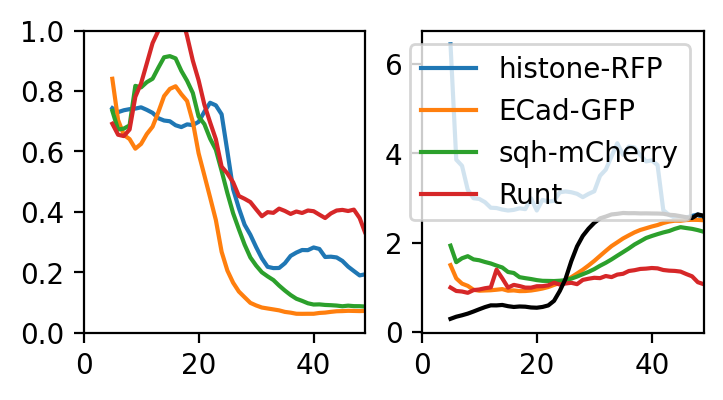

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2), dpi=200, sharex=True)

df = pd.concat(
    [pd.read_csv(csv) for csv in glob.glob('data/reservoir_results/*.csv')], 
    ignore_index=True)

for label in df.label.unique():
    sub = df[df.label == label]
    sub = sub.groupby('time').agg('mean').reset_index()
    
    ax[0].plot(sub.time, sub.res)
    ax[1].plot(sub.time, sub.v2, label=label)
    
df = df.groupby('time').agg('mean').reset_index()
ax[1].plot(df.time, df.v02, color='black')

ax[0].set_xlim([0, 49])
ax[0].set_ylim([0, 1])
ax[1].legend()

100%|██████████| 6/6 [00:00<00:00, 597.24it/s]


ECad-GFP ECad-GFP (31, 4, 236, 200) (31, 15, 2, 236, 200)
ECad-GFP ECad-GFP (31, 4, 236, 200) (31, 15, 2, 236, 200)
ECad-GFP ECad-GFP (30, 4, 236, 200) (30, 15, 2, 236, 200)
ECad-GFP ECad-GFP (27, 4, 236, 200) (27, 15, 2, 236, 200)
ECad-GFP ECad-GFP (19, 4, 236, 200) (19, 15, 2, 236, 200)
ECad-GFP ECad-GFP (21, 4, 236, 200) (21, 15, 2, 236, 200)
(30, 4, 236, 200) (30, 15, 2, 236, 200)
(15, 4, 236, 200)


Text(0, 0.5, 'ML')

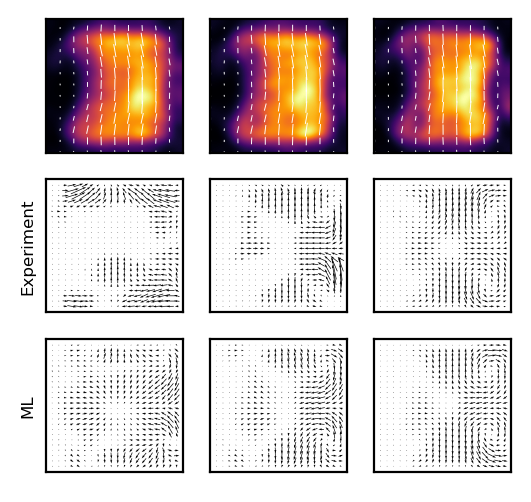

In [70]:
key = 'ECad-GFP'
X, y0, times, eIDs = get_data(key, max_len=15)
tt = -3

model = Pipeline([
    ('Flatten', Flatten()),
    #('SVD', TruncatedSVD(n_components=128)),
    ('Embedding', SparseRandomProjection(n_components=1024)),
    ('Reservoir', Reservoir(alpha=500, spectral_radius=0.9))
])

ii = 2
tt = 12
print(X[ii].shape, y0[ii].shape)
model.fit(np.concatenate([X[i] for i in range(len(X)) if not i == ii]), 
          np.concatenate([y0[i] for i in range(len(y0)) if not i == ii]))
y = model.predict(X[ii][tt:tt+1])[0]
y0 = y0[ii][tt]
X = X[ii][tt:tt+y0.shape[0]]
print(X.shape)
from utils.plot_utils import *
fig, ax = plt.subplots(3, 3, dpi=200, figsize=(3, 3))
for i in range(ax.shape[1]):
    plot_tensor2D(ax[0, i], X[i*4])
    ax[0, i].set_aspect('auto')
    plot_vector2D(ax[1, i], y0[i*4])
    plot_vector2D(ax[2, i], y[i*4])
    
    
ax[1, 0].set_ylabel('Experiment', fontsize=6)
ax[2, 0].set_ylabel('ML', fontsize=6)

# Verify morphodynamic timeline

100%|██████████| 5/5 [00:00<00:00, 443.95it/s]


[(0.0, 50.0), Text(0.5, 0, 'Time'), Text(0, 0.5, 'Flow strength')]

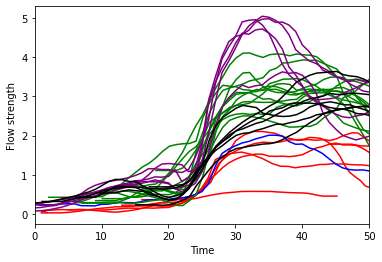

In [3]:
from utils.dataset import *

transform = Reshape2DField()
offsets = pd.read_csv('Figures/morphodynamic_offsets.csv', index_col=0)
'''
offsets.loc[202001281430, 'offset'] = 3
offsets.loc[202001210044, 'offset'] = 5
offsets.loc[202001210000, 'offset'] = 5
offsets.loc[202001141730, 'offset'] = -2
offsets.loc[201406122111, 'offset'] = -4
offsets.loc[20140612184500, 'offset'] = 4
offsets.loc[20140612211100, 'offset'] = -4
offsets.loc[20140912174700, 'offset'] = -8
offsets.loc[20140916131600, 'offset'] = -14
offsets.loc[20140917212700, 'offset'] = -20
offsets.loc[offsets.label=='moesin-GFP', 'offset'] = 3
'''

def plot_dataset_velocity(ax, dataset, legend=False, **kwargs):
    for eId in dataset.df.embryoID.unique():
        df = dataset.df[dataset.df.embryoID == eId]
        mag = np.linalg.norm(dataset.values[eId], axis=1).mean(axis=(1, 2))
        #mag = (mag - mag.min()) / np.ptp(mag)
        if not eId in offsets.index:
            offsets.loc[eId, 'offset'] = 0.
            offsets.loc[eId, 'genotype'] = dataset.genotype
            offsets.loc[eId, 'label'] = dataset.path.split('/')[-1]
        if legend:
            ax.plot(df.time + offsets.loc[eId, 'offset'], mag, label=eId, **kwargs)
        else:
            ax.plot(df.time + offsets.loc[eId, 'offset'], mag, **kwargs)
    if legend:
        ax.legend()
        
ax = plt.figure().gca()
plot_dataset_velocity(ax, AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform), 
                      color='black', zorder=10)
plot_dataset_velocity(ax, AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform), 
                      color='red')
plot_dataset_velocity(ax, AtlasDataset('WT', 'Even_Skipped', 'velocity2D', drop_no_time=False, transform=transform), 
                      color='blue')
plot_dataset_velocity(ax, AtlasDataset('WT', 'moesin-GFP', 'velocity2D', transform=transform), 
                      color='green')
plot_dataset_velocity(ax, AtlasDataset('WT', 'histone-RFP', 'velocity2D', drop_no_time=False, transform=transform), 
                      color='purple')

ax.set(xlim=[0, 50], #ylim=[0, 1], 
       xlabel='Time',
       ylabel='Flow strength')
#offsets.to_csv('morphodynamic_offsets.csv')
#offsets